Computing the pearson similarity matrix...
Done computing similarity matrix.


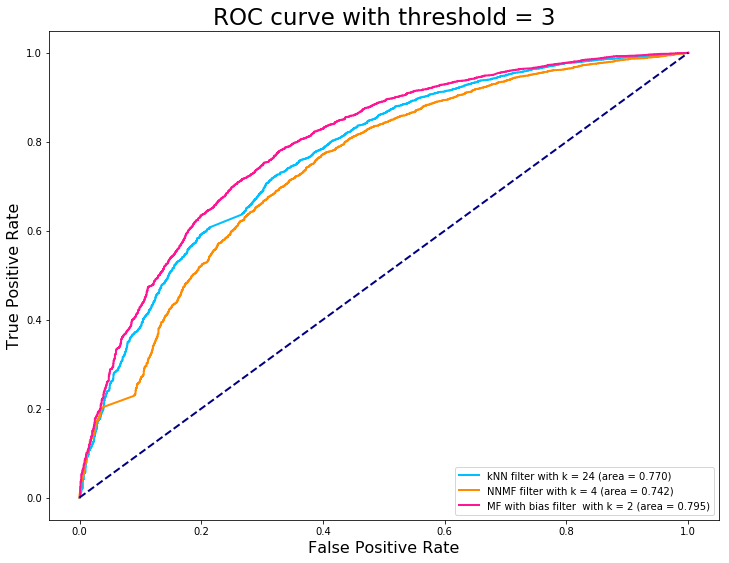

In [11]:
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import KFold
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import  roc_curve
from sklearn.metrics import roc_auc_score


# load data
file_path = os.path.expanduser('ratings.csv')
reader = Reader(line_format='user item rating', sep=',',skip_lines=1, rating_scale=(0.5, 5))
data = Dataset.load_from_file(file_path, reader=reader)

# calculate roc parameters
def cal_roc(model):
    train, test = train_test_split(data, train_size=0.9, test_size=0.1)
    model.fit(train)
    predictions = model.test(test)
    real_y = []
    est_y = []
    for i in range(len(predictions)):
        est_y.append(predictions[i].est)
        if test[i][2] >= 3:
            real_y.append(1)
        else:
            real_y.append(0)
    
    fpr, tpr, _ = roc_curve(real_y, est_y)
    roc_auc = roc_auc_score(real_y, est_y)
    
    return fpr, tpr, roc_auc

# 1 KNN filter, k=24
sim_options = {'name': 'pearson'}
knn = KNNWithMeans(k=24, sim_options=sim_options)
knn_fpr, knn_tpr, knn_auc = cal_roc(knn)

# 2 NNMF filter, k=4
nnmf = NMF(n_factors=4)
nnmf_fpr, nnmf_tpr, nnmf_auc = cal_roc(nnmf)

# 3 MF with bias filter, k=2
nmf_biased = NMF(n_factors=2, biased=True)
mf_bias_fpr, mf_bias_tpr, mf_bias_auc = cal_roc(nmf_biased)

# draw roc curve in one figure
plt.figure(figsize=(12,9))
plt.plot(knn_fpr, knn_tpr, color='deepskyblue', lw=2, label='kNN filter with k = 24 (area = %0.3f)' % knn_auc)
plt.plot(nnmf_fpr, nnmf_tpr, color='darkorange', lw=2, label='NNMF filter with k = 4 (area = %0.3f)' % nnmf_auc)
plt.plot(mf_bias_fpr, mf_bias_tpr, color='deeppink', lw=2, label='MF with bias filter  with k = 2 (area = %0.3f)' % mf_bias_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve with threshold = 3', fontsize=23)
plt.legend(loc="lower right")
plt.show()
